In [7]:
# Goal: Load SUPPORT2 → preprocess → train Cox PH → evaluate C-index → plot a few survival curves

#Cell 1: Project path setup + imports

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_PATH:", SRC_PATH)

from survcf.data import load_support2, prepare_survival_dataset, train_test_split_survival
from survcf.survival_models import CoxSurvivalModel
from survcf.metrics import c_index, risk_from_cox


PROJECT_ROOT: C:\Users\samee\Desktop\survcf-support2
SRC_PATH: C:\Users\samee\Desktop\survcf-support2\src


In [8]:
# Cell 2: Load dataset (SUPPORT2)
# Dataset: https://www.kaggle.com/datasets/joebeachcapital/support2
csv_path = os.path.join(PROJECT_ROOT, "data", "raw", "support2.csv")

df = load_support2(csv_path)
print(df.shape)
df.head()


(9105, 47)


,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,...,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11.0,...,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,NaN,7.0
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,<2 mo. follow-up,1.0
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,<2 mo. follow-up,0.0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11.0,...,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,no(M2 and SIP pres),0.0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,...,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,no(M2 and SIP pres),2.0


In [9]:
#Cell 3: Confirm key columns exist

required_cols = ["d.time", "death"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}\nFound columns:\n{list(df.columns)}")

df[["d.time", "death"]].describe(include="all")


,d.time,death
count,9105.000000,9105.000000
mean,478.449863,0.681054
std,560.383272,0.466094
min,3.000000,0.000000
25%,26.000000,0.000000
50%,233.000000,1.000000
75%,761.000000,1.000000
max,2029.000000,1.000000


In [10]:
#Cell 4: Prepare survival dataset (no treatment here)

X, T, y_time, y_event, meta = prepare_survival_dataset(
    df,
    time_col="d.time",
    event_col="death",
    treatment_col=None,      # survival-only notebook
    id_col=None,
    min_followup_days=1.0
)

print("X shape:", X.shape)
print("y_time shape:", y_time.shape)
print("y_event event rate:", y_event.mean())
X.head()


X shape: (9105, 67)
y_time shape: (9105,)
y_event event rate: 0.6810543657331136


,age,hospdead,slos,num.co,edu,scoma,charges,totcst,totmcst,avtisst,...,ca_no,ca_yes,dnr_dnr before sadm,dnr_missing,dnr_no dnr,sfdm2_Coma or Intub,sfdm2_SIP>=30,sfdm2_adl>=4 (>=5 if sur),sfdm2_missing,sfdm2_no(M2 and SIP pres)
1,62.84998,0,5,0,11.0,0.0,9715.0,14452.7344,13223.5,7.000000,...,False,False,False,False,True,False,False,False,True,False
2,60.33899,1,4,2,12.0,44.0,34496.0,14452.7344,13223.5,29.000000,...,True,False,False,True,False,False,False,False,False,False
3,52.74698,0,17,2,12.0,0.0,41094.0,14452.7344,13223.5,13.000000,...,True,False,False,False,True,False,False,False,False,False
4,42.38498,0,3,2,11.0,0.0,3075.0,14452.7344,13223.5,7.000000,...,False,False,False,False,True,False,False,False,False,True
5,79.88495,0,16,1,12.0,26.0,50127.0,14452.7344,13223.5,18.666656,...,True,False,False,False,True,False,False,False,False,True


In [11]:
#Cell 5: Train/test split

(X_tr, _, t_tr, e_tr), (X_te, _, t_te, e_te) = train_test_split_survival(
    X, None, y_time, y_event,
    test_size=0.2,
    random_state=42
)

print("Train:", X_tr.shape, "Test:", X_te.shape)
print("Train event rate:", e_tr.mean(), "Test event rate:", e_te.mean())


Train: (7284, 67) Test: (1821, 67)
Train event rate: 0.6810818231740802 Test event rate: 0.6809445359692476


In [12]:
#Cell 6: Fit Cox PH model + evaluate C-index

cox = CoxSurvivalModel(penalizer=0.01, l1_ratio=0.0)
cox.fit(X_tr, t_tr, e_tr)

risk_te = risk_from_cox(cox, X_te)
ci = c_index(t_te, e_te, risk_te)

print(f"CoxPH Test C-index: {ci:.4f}")


CoxPH Test C-index: 0.8662


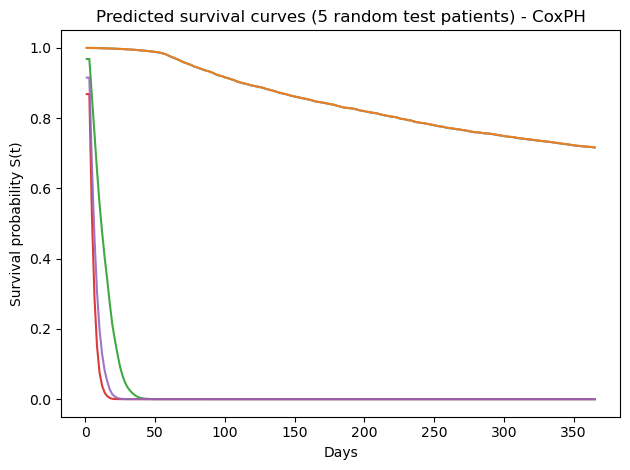

In [13]:
#Cell 7: Plot survival curves for a few random patients

np.random.seed(42)
idx = np.random.choice(len(X_te), size=5, replace=False)
X_sample = X_te.iloc[idx]

times = np.linspace(1, 365, 200)  # up to 1 year
sf = cox.predict_survival_curve(X_sample, times=times)

plt.figure()
for col in sf.columns:
    plt.plot(sf.index, sf[col], alpha=0.9)

plt.xlabel("Days")
plt.ylabel("Survival probability S(t)")
plt.title("Predicted survival curves (5 random test patients) - CoxPH")
plt.tight_layout()
plt.show()


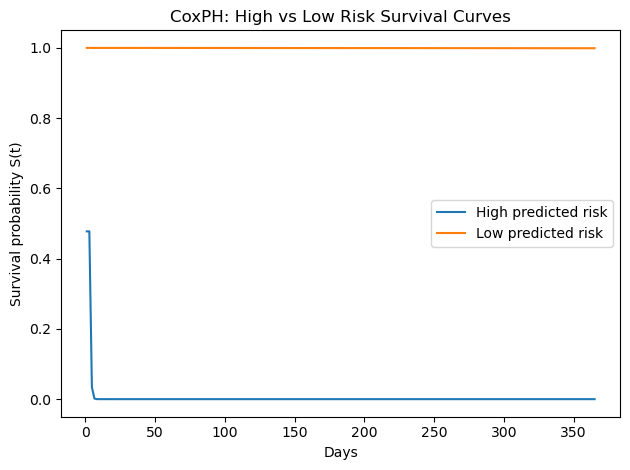

In [14]:
# Cell 8: Show “Top risk” vs “Low risk” example curves

# pick highest risk and lowest risk patients from test set
risk_order = np.argsort(-risk_te)  # descending
high_idx = risk_order[0]
low_idx  = risk_order[-1]

X_pair = X_te.iloc[[high_idx, low_idx]]
times = np.linspace(1, 365, 200)
sf_pair = cox.predict_survival_curve(X_pair, times=times)

plt.figure()
plt.plot(sf_pair.index, sf_pair.iloc[:, 0], label="High predicted risk")
plt.plot(sf_pair.index, sf_pair.iloc[:, 1], label="Low predicted risk")
plt.xlabel("Days")
plt.ylabel("Survival probability S(t)")
plt.title("CoxPH: High vs Low Risk Survival Curves")
plt.legend()
plt.tight_layout()
plt.show()
